In [1]:
# using pandas to process data
from collections import Counter
import numpy as np
import pandas as pd
import datetime
from matplotlib import pyplot as plt
%matplotlib inline
from scipy.stats import pearsonr

## 1.数据载入
使用预处理后的数据，不使用原始数据

In [2]:
def load_bj_aq_data(aq_df):

    '''
    aq_df : a dataframe after concat.
    '''
    aq_dataset = aq_df

    # turn date from string type to datetime type
    aq_dataset["time"] = pd.to_datetime(aq_dataset['utc_time'])
    aq_dataset.set_index("time", inplace=True)
    aq_dataset.drop("utc_time", axis=1, inplace=True)

    aq_dataset = aq_dataset[pd.isnull(aq_dataset.stationId) != True]

    # names of all stations
    stations = set(aq_dataset['stationId'])
    # print(stations)

    # a dict of station aq
    aq_stations = {}
    for station in stations:
        aq_station = aq_dataset[aq_dataset["stationId"]==station].copy()
        aq_station.drop("stationId", axis=1, inplace=True)

        # rename
        original_names = aq_station.columns.values.tolist()
        names_dict = {original_name : station+"_"+original_name for original_name in original_names}
        aq_station.rename(index=str, columns=names_dict, inplace=True)
        aq_station.drop_duplicates(inplace=True)
        aq_stations[station] = aq_station
        # print(aq_station.shape)

    # for station in stations :
    # print(aq_stations[station].shape)

    # merge data of different stations into one df
    aq_stations_merged = pd.concat(list(aq_stations.values()), axis=1)
    # add a column of (0,1,2,3,...) to count
    length = aq_stations_merged.shape[0]
    order = range(length)
    aq_stations_merged['order'] = pd.Series(order, index=aq_stations_merged.index)

    return aq_dataset, stations, aq_stations, aq_stations_merged

In [3]:
# load the data again
bj_aq_stations_merged = pd.read_csv('data/test/bj_aq_data.csv')

In [6]:
# bj_aq_stations_merged.shape(11626,211)此时是全部时间段补齐的结果
# 在空气质量数据时间段内，总共应该有11626个小时节点。
# 去掉缺失值所在行
for index in bj_aq_stations_merged.index:
    if pd.isnull(bj_aq_stations_merged.loc[index]).any():
        bj_aq_stations_merged.drop([index], inplace=True)
bj_aq_stations_merged.shape #(11005, 210)

(11005, 211)

In [8]:
bj_aq_stations_merged.head()

,time,gucheng_aq_PM2.5,gucheng_aq_PM10,gucheng_aq_NO2,gucheng_aq_CO,gucheng_aq_O3,gucheng_aq_SO2,tiantan_aq_PM2.5,tiantan_aq_PM10,tiantan_aq_NO2,...,tongzhou_aq_NO2,tongzhou_aq_CO,tongzhou_aq_O3,tongzhou_aq_SO2,dingling_aq_PM2.5,dingling_aq_PM10,dingling_aq_NO2,dingling_aq_CO,dingling_aq_O3,dingling_aq_SO2
0,2017-01-01 14:00:00,500.0,612.0,161.0,7.7,3.0,11.0,357.0,449.0,116.0,...,128.0,5.1,2.0,9.0,339.0,372.0,137.0,5.9,6.0,18.0
1,2017-01-01 15:00:00,490.0,594.0,150.0,7.9,3.0,11.0,351.0,467.0,109.0,...,131.0,5.4,3.0,10.0,343.0,572.0,137.0,5.4,4.0,19.0
2,2017-01-01 16:00:00,513.0,618.0,157.0,8.7,4.0,11.0,346.0,451.0,101.0,...,128.0,6.2,3.0,10.0,311.0,550.0,123.0,5.1,5.0,13.0
3,2017-01-01 17:00:00,528.0,609.0,170.0,9.9,4.0,13.0,339.0,447.0,98.0,...,146.0,6.5,4.0,12.0,256.0,518.0,118.0,4.1,3.0,17.0
4,2017-01-01 18:00:00,297.0,423.0,92.0,4.4,15.0,11.0,345.0,471.0,101.0,...,144.0,6.8,4.0,12.0,57.0,504.0,33.0,0.8,43.0,17.0


# 2. 相同特征不同站点之间的相关性

In [7]:
# 站点的具体位置
station_locations = pd.read_csv('data/Beijing_AirQuality_Stations_en.csv')
station_locations.head()

,stationId,latitude,longitude,stationType
0,dongsi_aq,39.929,116.417,Urban Stations
1,tiantan_aq,39.886,116.407,Urban Stations
2,guanyuan_aq,39.929,116.339,Urban Stations
3,wanshouxigong_aq,39.878,116.352,Urban Stations
4,aotizhongxin_aq,39.982,116.397,Urban Stations


In [12]:
# compute the distance for any two stationId in air_quality station
def calculate_distance(station_1, station_2, station_locations):
    '''
    station_1, station_2: names of two stations
    station_locations: a dataframe of "stationId'|'latitude'|'longitude'|stationType'
    '''
    location_1 = station_locations[station_1+'_aq' == station_locations['stationId']]
    location_2 = station_locations[station_2+'_aq' == station_locations['stationId']]
    dis = np.sqrt((location_1['longitude'].values[0] - location_2['longitude'].values[0])**2+
                  (location_1['latitude'].values[0] - location_2['latitude'].values[0])**2)
    return dis

In [13]:
def calculate_r_distance_relations(dataframe, feature):
    '''
    dataframe: dateframe with all data
    feature: feature that want to compare
    '''
    features = [name for name in dataframe.columns if feature in name]
    df = dataframe[features]
    
    relations = pd.DataFrame(columns=['station_1', 'station_2', 'r', 'distance'])
    for i in range(len(features)-1):
        for j in range(i+1, len(features)):
            station_1 = features[i].split('_')[0]
            station_2 = features[j].split('_')[0]
            ts_station_1 = df[features[i]]
            ts_station_2 = df[features[j]]
            r = pearsonr(ts_station_1, ts_station_2)[0]
            distance = calculate_distance(station_1, station_2, station_locations)
            s = pd.Series({'station_1':station_1, 'station_2':station_2, 'r':r, 'distance':distance})
            relations = relations.append(s, ignore_index=True)
    
    # order by r
    relations = relations.sort_values(by=['r'], ascending=False)
    
    plt.subplot(2,1,1)
    plt.plot(range(len(relations)), relations['r']);
    plt.subplot(2,1,2)
    plt.plot(range(len(relations)), relations['distance']);
    
    r = pearsonr(relations['r'].values, relations['distance'].values)[0]
    print('r=', r)
    return relations, r

r= -0.7776390076845455


D:\Anaconda\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


r= -0.8233083334288264
r= -0.7665545841346856


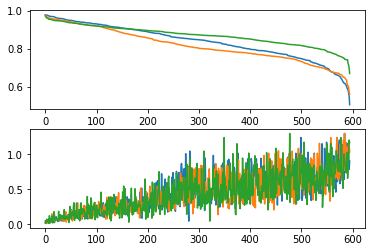

In [16]:
for feature in ['PM2.5', 'PM10', 'O3']:
    relations, r = calculate_r_distance_relations(bj_aq_stations_merged, feature)


summary:
(1)可以看出‘距离’与‘相关性’存在负相关关系:
    for 'PM2.5': r= -0.7776390076845455;
    for 'PM10': r= -0.8233083334288264;
    for 'O3': r= -0.7665545841346856;
    
(2) 相关性范围在range(0.5, 1)


# 3. 空气质量的‘天’的周期性

In [17]:
bj_aq_stations_merged.set_index('time', inplace=True)

bj_aq_stations_merged['new'] = bj_aq_stations_merged.index
bj_aq_stations_merged['new'] = pd.to_datetime(bj_aq_stations_merged['new'])

In [18]:
bj_aq_stations_merged.head()

,gucheng_aq_PM2.5,gucheng_aq_PM10,gucheng_aq_NO2,gucheng_aq_CO,gucheng_aq_O3,gucheng_aq_SO2,tiantan_aq_PM2.5,tiantan_aq_PM10,tiantan_aq_NO2,tiantan_aq_CO,...,tongzhou_aq_CO,tongzhou_aq_O3,tongzhou_aq_SO2,dingling_aq_PM2.5,dingling_aq_PM10,dingling_aq_NO2,dingling_aq_CO,dingling_aq_O3,dingling_aq_SO2,new
time,,,,,,,,,,,,,,,,,,,,,
2017-01-01 14:00:00,500.0,612.0,161.0,7.7,3.0,11.0,357.0,449.0,116.0,6.2,...,5.1,2.0,9.0,339.0,372.0,137.0,5.9,6.0,18.0,2017-01-01 14:00:00
2017-01-01 15:00:00,490.0,594.0,150.0,7.9,3.0,11.0,351.0,467.0,109.0,6.4,...,5.4,3.0,10.0,343.0,572.0,137.0,5.4,4.0,19.0,2017-01-01 15:00:00
2017-01-01 16:00:00,513.0,618.0,157.0,8.7,4.0,11.0,346.0,451.0,101.0,6.6,...,6.2,3.0,10.0,311.0,550.0,123.0,5.1,5.0,13.0,2017-01-01 16:00:00
2017-01-01 17:00:00,528.0,609.0,170.0,9.9,4.0,13.0,339.0,447.0,98.0,6.6,...,6.5,4.0,12.0,256.0,518.0,118.0,4.1,3.0,17.0,2017-01-01 17:00:00
2017-01-01 18:00:00,297.0,423.0,92.0,4.4,15.0,11.0,345.0,471.0,101.0,6.9,...,6.8,4.0,12.0,57.0,504.0,33.0,0.8,43.0,17.0,2017-01-01 18:00:00


In [26]:
def feature_trend_in_one_day(bj_aq_stations_merged, feature):
    '''
    look the trend in 24 hour for a feature for different location
    '''
    df = bj_aq_stations_merged[['new', feature]]
    # initial values
    d = datetime.timedelta(hours=24)
    
    #最早的日期： 2017-01-01 14:00:00|最晚的日期： 2018-04-30 23:00:00, 共484天
    t_start = datetime.datetime(2017,1,2,0,0,0)
    t_end = datetime.datetime(2017,1,3,0,0,0)
    
    all_days = []
    all_days_dfs = []
    for i in range(445):
        df = bj_aq_stations_merged[['new', feature]]
        df_part = df[df['new'] < t_end]
        df_part = df_part[df_part['new'] >= t_start]
        
        all_days.append(df_part[feature].values) #445天，每天中所有不缺失的值（仅value部分）
        all_days_dfs.append(df_part) #445天，每天的df_part(每个元素都是一个df)
        t_start += d
        t_end += d
    
#     print('len(all_days):', len(all_days))
#     print('all_days[0].shape:', all_days[0].shape)
#     print(all_days[0])
#     print('len(all_days_dfs):', len(all_days_dfs))
#     print('all_days_dfs[0].shape:', all_days_dfs[0].shape)
#     print(all_days_dfs[0])

    
    bias_all_days = []
    for day in all_days:
        if len(day) == 24:
            init = day[0]
            bias_day = [i - init for i in day]
            bias_all_days.append(bias_day) # 所有包含完整24小时数据的天数，每天中24小时的值
    
#     print('len(bias_all_days):', len(bias_all_days))
#     print(bias_all_days[0])
    
    bias_all_days = np.array(bias_all_days) # array.shape(n, 24)
    day = np.mean(bias_all_days, axis=0) # 按列取平均，看一天内平均的波动情况
    plt.plot(day);      

In [25]:
pm25 = [i for i in bj_aq_stations_merged.columns if 'PM2.5' in i]
# obtain the list of names:station_aq_PM2.5
pm10 = [i for i in bj_aq_stations_merged.columns if 'PM10' in i]
O3 = [i for i in bj_aq_stations_merged.columns if 'O3' in i]
NO2 = [i for i in bj_aq_stations_merged.columns if 'NO2' in i]
SO2 = [i for i in bj_aq_stations_merged.columns if 'SO2' in i]
CO = [i for i in bj_aq_stations_merged.columns if 'CO' in i]

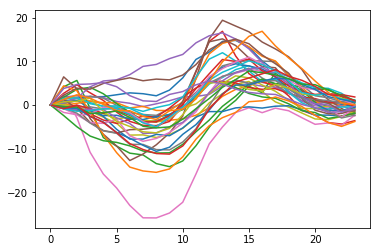

In [27]:
for feature in pm25:
    feature_trend_in_one_day(bj_aq_stations_merged, feature)

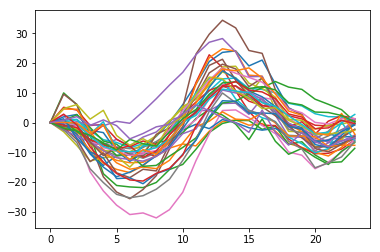

In [28]:
for feature in pm10:
    feature_trend_in_one_day(bj_aq_stations_merged, feature)

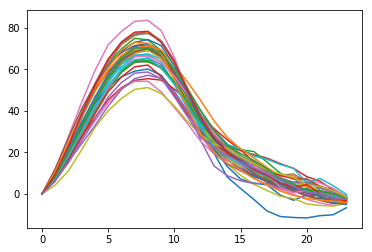

In [29]:
for feature in O3:
    feature_trend_in_one_day(bj_aq_stations_merged, feature)

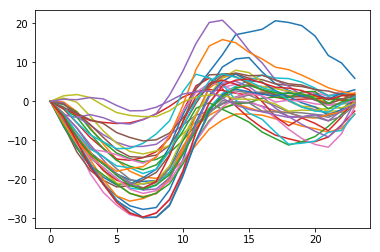

In [30]:
for feature in NO2:
    feature_trend_in_one_day(bj_aq_stations_merged, feature)

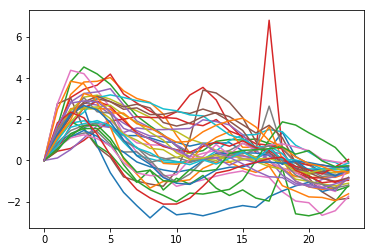

In [31]:
for feature in SO2:
    feature_trend_in_one_day(bj_aq_stations_merged, feature)

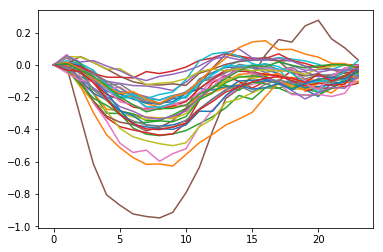

In [32]:
for feature in CO:
    feature_trend_in_one_day(bj_aq_stations_merged, feature)

summary:
(1)不同特征在一天之内呈现出不同的变化趋势：可以考虑单个特征建模|多个特征建模;
(2)各站点之间在3个特征间呈现出强相关性（r系数range(0.5-1))， 因此可以考虑单个站点建模|多个站点建模。